In [104]:
#pip install torch torch_geometric pandas numpy scikit-learn
#!pip install networkx matplotlib



In [105]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your file path)
file_path = r"C:\Users\91924\Desktop\MY WORKS\sem 8\social media analytics\archive (15)\ratings.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at '{file_path}'")
    exit()


# 1. Check for Null Values
print("Null Values:\n", df.isnull().sum())

# 2. Remove Null Values (if any)
df = df.dropna()  # Removes rows with any null values
print("\nNull Values After Removal:\n", df.isnull().sum())

# 3. Basic Statistics
print("\nBasic Statistics:\n", df.describe())



Null Values:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Null Values After Removal:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Basic Statistics:
               userId        movieId         rating     timestamp
count  100836.000000  100836.000000  100836.000000  1.008360e+05
mean      326.127564   19435.295718       3.501557  1.205946e+09
std       182.618491   35530.987199       1.042529  2.162610e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8122.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09


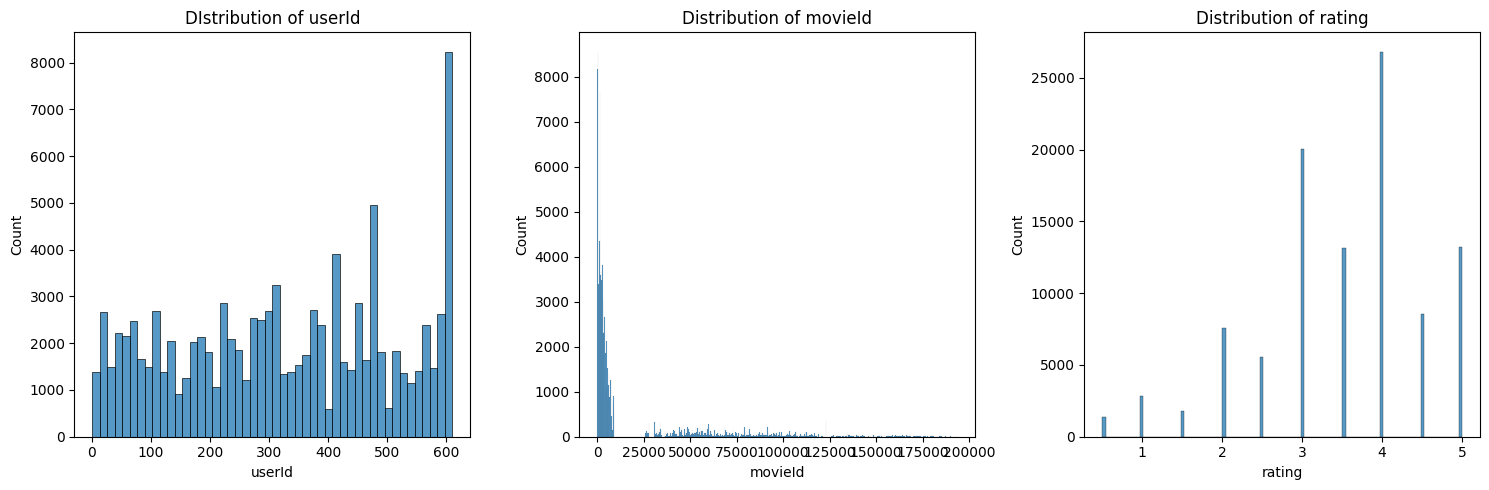

In [106]:
# 4. Histograms
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['userId'], kde=False)
plt.title('DIstribution of userId')

plt.subplot(1, 3, 2)
sns.histplot(df['movieId'], kde=False)
plt.title('Distribution of movieId')

plt.subplot(1, 3, 3)
sns.histplot(df['rating'], kde=False)
plt.title('Distribution of rating')
plt.tight_layout()
plt.show()



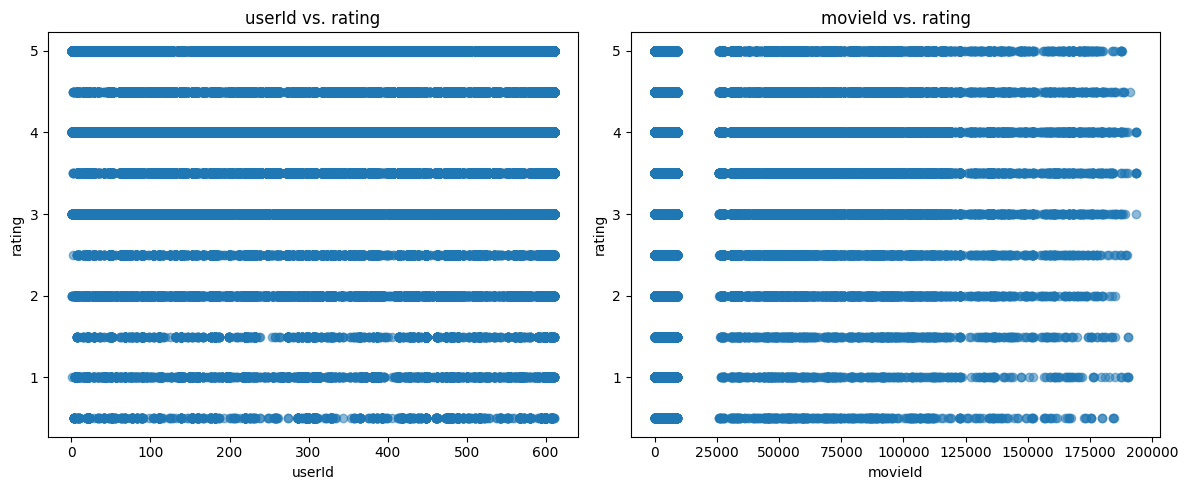

In [107]:
# 5. Scatter Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df['userId'], df['rating'], alpha=0.5)
plt.title('userId vs. rating')
plt.xlabel('userId')
plt.ylabel('rating')

plt.subplot(1, 2, 2)
plt.scatter(df['movieId'], df['rating'], alpha=0.5)
plt.title('movieId vs. rating')
plt.xlabel('movieId')
plt.ylabel('rating')
plt.tight_layout()
plt.show()



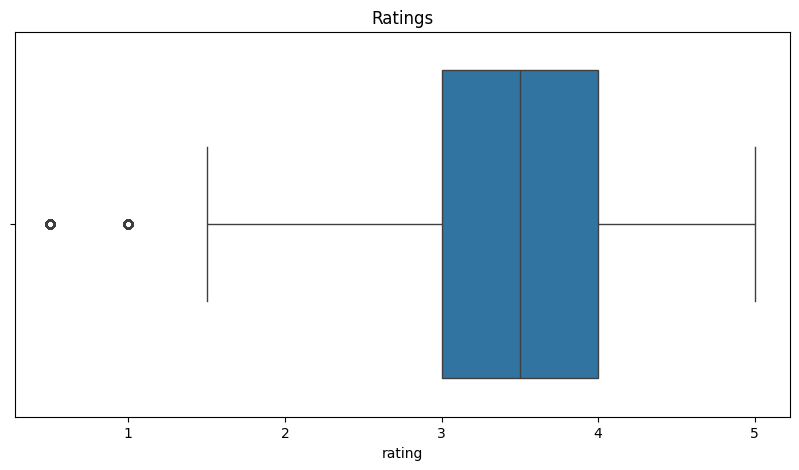

In [108]:
# 6. Box Plots
plt.figure(figsize=(10, 5))
sns.boxplot(x='rating', data=df)
plt.title('Ratings')
plt.show()



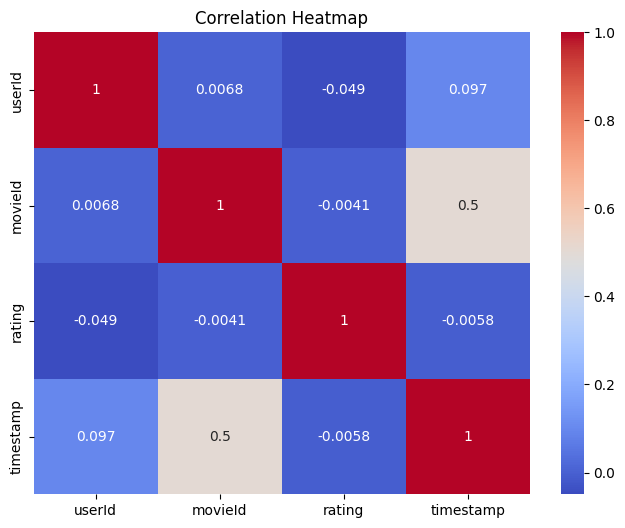

In [109]:
# 7. Correlation Heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()



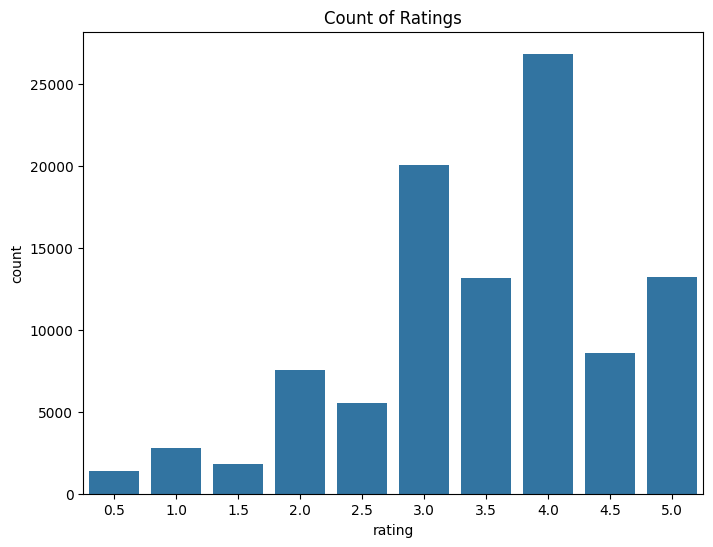

In [110]:
# 8. Value Counts of Ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=df)
plt.title('Count of Ratings')
plt.show()



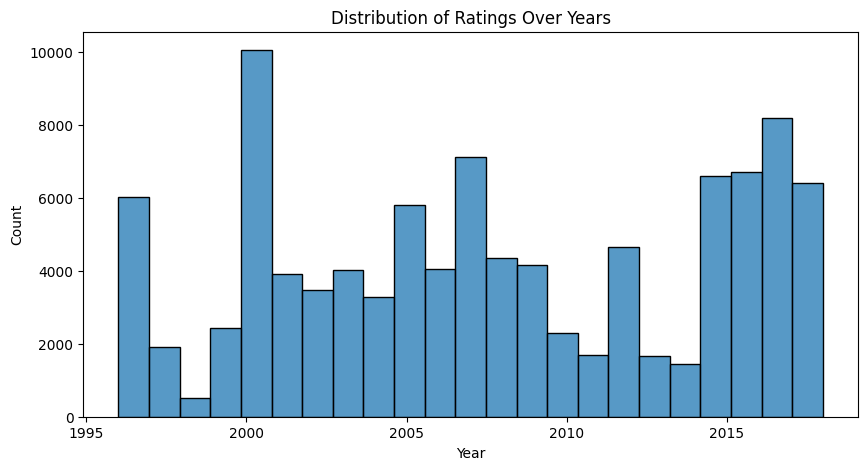

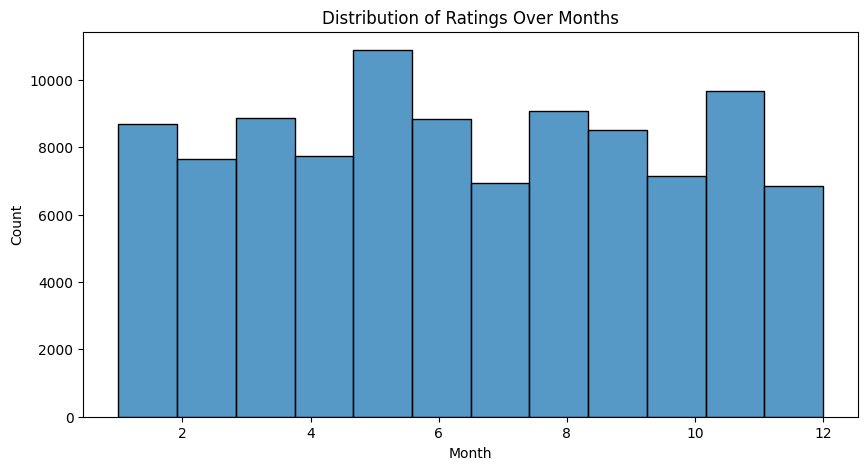

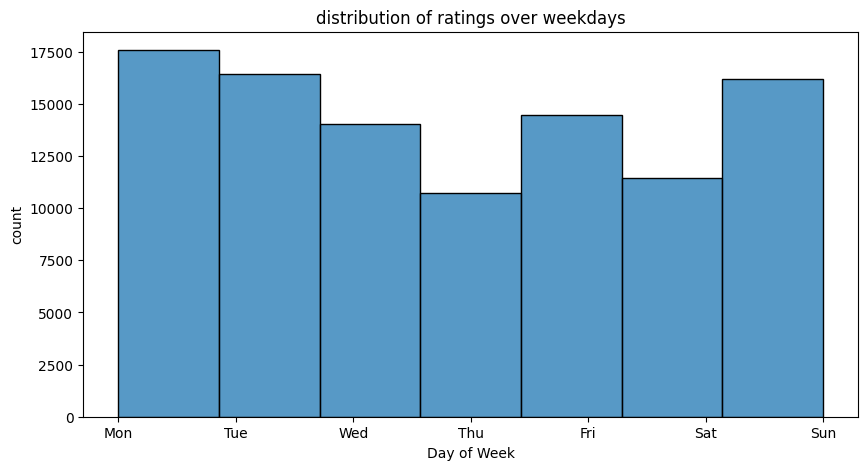

In [111]:
# 9. Timestamp Distribution:

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s') #convert to datetime
plt.figure(figsize=(10, 5))
sns.histplot(df['timestamp'].dt.year, bins=df['timestamp'].dt.year.nunique(), kde=False)
plt.title('Distribution of Ratings Over Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df['timestamp'].dt.month, bins=12, kde=False)
plt.title('Distribution of Ratings Over Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df['timestamp'].dt.dayofweek, bins = 7, kde = False)
plt.title("distribution of ratings over weekdays")
plt.xlabel("Day of Week")
plt.ylabel("count")
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

In [186]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data


# Load MovieLens dataset (adjust the file path as needed)
ratings = pd.read_csv(r"C:\Users\91924\Desktop\MY WORKS\sem 8\social media analytics\archive (15)\ratings.csv")
users = ratings['userId'].unique()
movies = ratings['movieId'].unique()

# Create user-item interaction graph
user_to_idx = {user: i for i, user in enumerate(users)}
movie_to_idx = {movie: i + len(users) for i, movie in enumerate(movies)}

# Create edge list (user-movie interactions)
edges = [(user_to_idx[u], movie_to_idx[m]) for u, m in zip(ratings['userId'], ratings['movieId'])]
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Node Features (random initialization for simplicity)
num_users = len(users)
num_movies = len(movies)
user_features = torch.randn((num_users, 64))   # 64-dim embeddings for users
movie_features = torch.randn((num_movies, 64))  # 64-dim embeddings for movies
x = torch.cat([user_features, movie_features], dim=0)

# Labels (dummy labels: 1 for shilling attackers, 0 for normal users)
# Here, we mark 5% of users as attackers (movies are all labeled as 0)
y = torch.zeros(num_users + num_movies)
attacker_indices = np.random.choice(num_users, size=int(0.05 * num_users), replace=False)  # 5% attackers among users
y[attacker_indices] = 1

# Create the PyG Graph Data Object
data = Data(x=x, edge_index=edge_index, y=y)

# ------------------------------
# 2. Split Data into Train and Test
# ------------------------------
# We only split user nodes (first num_users nodes)
train_mask, test_mask = train_test_split(np.arange(num_users), test_size=0.2, random_state=42)
train_mask = torch.tensor(train_mask, dtype=torch.long)
test_mask = torch.tensor(test_mask, dtype=torch.long)

# ------------------------------
# 3. Define the AMV-GCN Model
# ------------------------------
class AMV_GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AMV_GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize the model, optimizer, and loss function
model = AMV_GCN(input_dim=64, hidden_dim=32, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

# ------------------------------
# 4. Training and Testing Functions
# ------------------------------
def train():
    model.train()
    optimizer.zero_grad()
    # Forward pass on the entire graph, then index only training user nodes
    out = model(data)[train_mask]
    loss = criterion(out, data.y[train_mask].long())
    loss.backward()
    optimizer.step()
    
    # Store all the predicted shilling attackers in a list
    predicted_attackers = []
    pred = out.argmax(dim=1)  # Get predicted classes for all users in the training set
    for idx in range(train_mask.size(0)):
        if pred[idx].item() == 1:  # If predicted as shilling attacker
            predicted_attackers.append(users[idx])  # Add user id to list
    
    return loss.item(), predicted_attackers

def test():
    model.eval()
    with torch.no_grad():
        out = model(data)[test_mask]
        pred = out.argmax(dim=1)
        acc = (pred == data.y[test_mask]).sum().item() / test_mask.size(0)
    return acc

# Train the model for a number of epochs
all_predicted_attackers = []  # List to store all predicted attackers across all epochs
for epoch in range(20):
    loss, predicted_attackers = train()
    all_predicted_attackers.extend(predicted_attackers)  # Add predicted attackers from this epoch
    
    if epoch % 10 == 0:
        acc = test()
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}')

# ------------------------------
# 5. Prediction Function for a Given User
# ------------------------------
def predict_shilling_attack(user_id):
    """
    Given a user_id, predict if the user is a shilling attacker (1) or normal (0).
    """
    # Ensure the user exists in our mapping
    if user_id not in user_to_idx:
        print(f"User id {user_id} not found in the dataset.")
        return None

    # Get the node index for the user
    user_idx = user_to_idx[user_id]

    # Run the model on the entire graph in evaluation mode
    model.eval()
    with torch.no_grad():
        output = model(data)
        # Extract the log-probabilities for this user and determine the class
        predicted_class = output[user_idx].argmax(dim=0).item()

    return predicted_class



# ------------------------------
# 6. User Input for Prediction
# ------------------------------
# You can run this part after training to predict for a given user
user_input = input("Enter a user ID to check for shilling attack: ")
try:
    user_input = int(user_input)
    prediction = predict_shilling_attack(user_input)
    if prediction is None:
        pass  # Error already printed
    elif prediction == 1:
        print(f"User {user_input} is predicted to be a shilling attacker.")
    else:
        print(f"User {user_input} is predicted to be normal.")
except ValueError:
    print("Please enter a valid integer user ID.")

# ------------------------------
# 7. Print Predicted Shilling Attackers List
# ------------------------------
print("Predicted Shilling Attackers (User IDs):")
print(list(set(all_predicted_attackers)))  # Remove duplicates and print unique attackers


Epoch 0, Loss: 0.5187, Test Accuracy: 0.9180
Epoch 10, Loss: 0.0983, Test Accuracy: 0.9754
User 4 is predicted to be normal.
Predicted Shilling Attackers (User IDs):
[7, 9, 12, 13, 16, 17, 33, 37, 41, 47, 64, 74, 75, 81, 88, 90, 98, 109, 114, 118, 121, 123, 128, 134, 150, 152, 154, 156, 158, 159, 163, 166, 167, 169, 175, 183, 184, 186, 188, 191, 194, 200, 201, 203, 210, 214, 216, 218, 225, 226, 228, 229, 231, 232, 235, 241, 242, 243, 249, 250, 255, 257, 259, 261, 262, 266, 270, 280, 282, 286, 295, 298, 301, 303, 309, 315, 316, 320, 321, 327, 329, 331, 336, 337, 338, 348, 350, 361, 373, 376, 383, 390, 395, 396, 397, 398, 401, 406, 410, 412, 414, 415, 417, 418, 423, 437, 438, 443, 448, 451, 455, 458, 459, 464, 467, 471, 472, 485, 487]


In [187]:
acc = test()
print(f"Overall Test Accuracy: {acc:.4f}")

Overall Test Accuracy: 0.9672


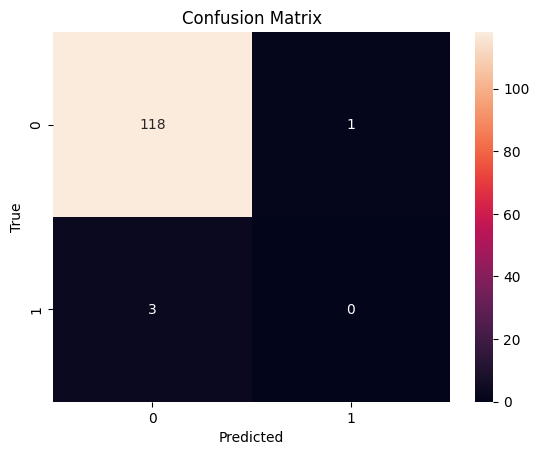

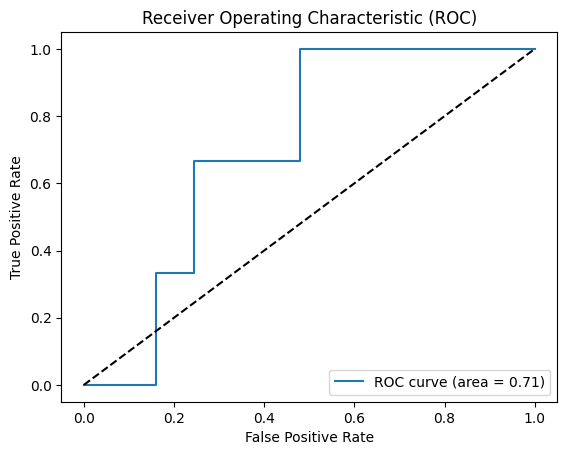

In [188]:
import torch
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming:
# - model: Trained PyTorch model (AMV_GCN)
# - data: PyTorch Geometric Data object
# - test_mask: Tensor containing the test user indices
# - losses: List containing the training losses per epoch

# Confusion Matrix
model.eval()
with torch.no_grad():
    out = model(data)[test_mask]
    pred = out.argmax(dim=1).numpy()
    true = data.y[test_mask].numpy()
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# AUC-ROC Curve
model.eval()
with torch.no_grad():
    out = model(data)[test_mask]
    probs = torch.softmax(out, dim=1).numpy()[:, 1]
    fpr, tpr, thresholds = roc_curve(true, probs)
    roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


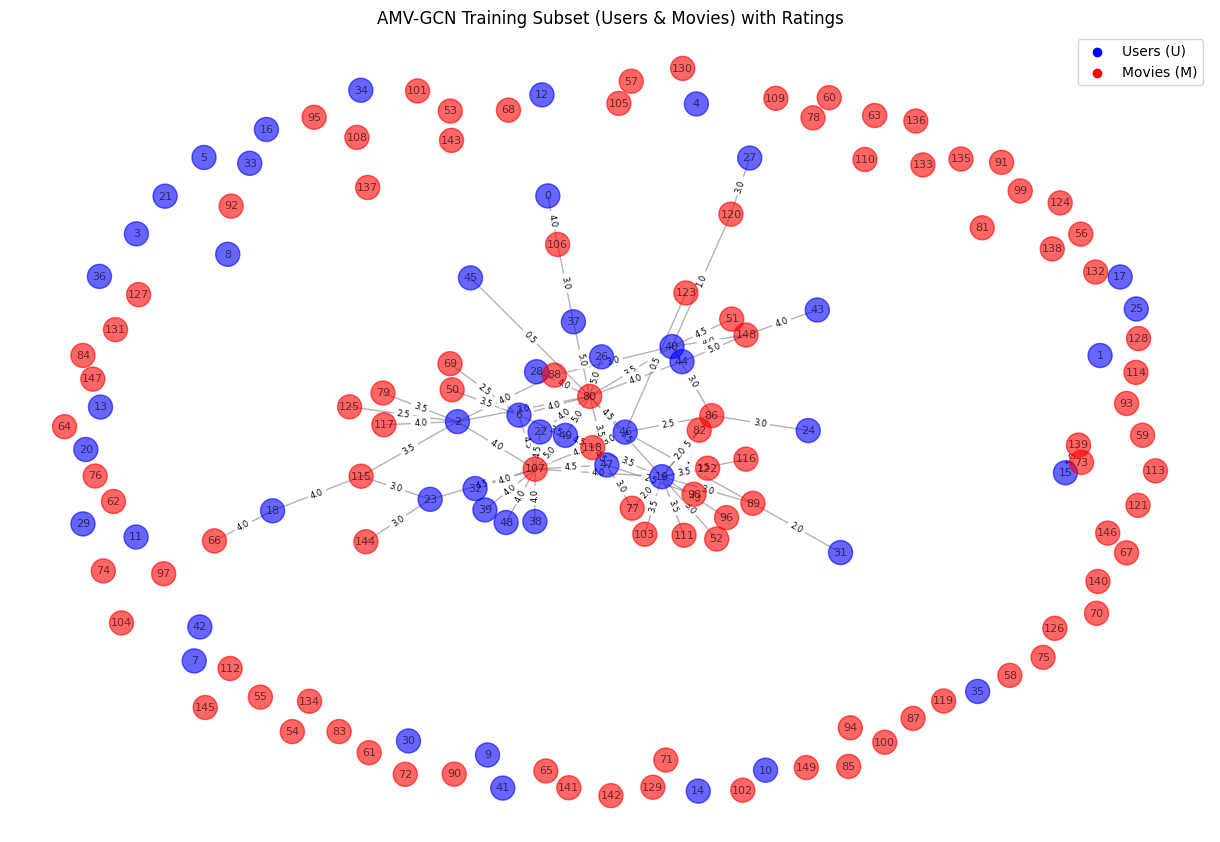

In [115]:
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data

# Load MovieLens dataset (Ensure the file exists)
ratings = pd.read_csv(r"C:\Users\91924\Desktop\MY WORKS\sem 8\social media analytics\archive (15)\ratings.csv")  # Contains 'userId', 'movieId', 'rating'

# SAMPLE A SMALLER SUBSET FOR AMV-GCN TRAINING
sample_users = np.random.choice(ratings['userId'].unique(), size=50, replace=False)  # 50 Users
sample_movies = np.random.choice(ratings['movieId'].unique(), size=100, replace=False)  # 100 Movies
subset_ratings = ratings[ratings['userId'].isin(sample_users) & ratings['movieId'].isin(sample_movies)]

# Create User and Movie Node Index Mapping
user_to_idx = {user: i for i, user in enumerate(sample_users)}
movie_to_idx = {movie: i + len(sample_users) for i, movie in enumerate(sample_movies)}

# Create Edge List (User-Movie Interactions) with Ratings
edges = [(user_to_idx[u], movie_to_idx[m], r) for u, m, r in zip(subset_ratings['userId'], subset_ratings['movieId'], subset_ratings['rating'])]

# Convert to PyG Edge Format
edge_index = torch.tensor([(e[0], e[1]) for e in edges], dtype=torch.long).t().contiguous()

# Initialize Node Features (Random Embeddings)
num_users = len(sample_users)
num_movies = len(sample_movies)
user_features = torch.randn((num_users, 64))  # 64-dim embeddings for users
movie_features = torch.randn((num_movies, 64))  # 64-dim embeddings for movies
x = torch.cat([user_features, movie_features], dim=0)  # Combine features

# Create Graph Data Object
data = Data(x=x, edge_index=edge_index)

# ---- GRAPH VISUALIZATION ----
def plot_graph(edges, num_users, num_movies):
    """Visualize a smaller training subset for AMV-GCN"""
    G = nx.Graph()

    # Add User Nodes (Blue)
    for user in range(num_users):
        G.add_node(user, type='user', color='blue', label=f"U{user}")

    # Add Movie Nodes (Red)
    for movie in range(num_movies):
        G.add_node(num_users + movie, type='movie', color='red', label=f"M{movie}")

    # Add Edges with Ratings
    edge_labels = {}
    for u, m, r in edges:
        G.add_edge(u, m, weight=r)
        edge_labels[(u, m)] = str(r)  # Store rating as label

    # Extract Node Colors
    color_map = ['blue' if node < num_users else 'red' for node in G.nodes()]

    # Use Circular Layout for better visibility
    pos = nx.spring_layout(G, seed=42, k=0.3)  # Adjust k to improve compactness

    # Draw Graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, node_color=color_map, node_size=300, edge_color='gray', alpha=0.6, with_labels=True, font_size=8)

    # Draw Edge Labels (Ratings)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=6, label_pos=0.5)

    # Add Legend
    plt.scatter([], [], color="blue", label="Users (U)")
    plt.scatter([], [], color="red", label="Movies (M)")
    plt.legend()

    plt.title("AMV-GCN Training Subset (Users & Movies) with Ratings")
    plt.show()

# Call the visualization function
plot_graph(edges, num_users, num_movies)
